# Games Dataset Classification (Optimized + Charts + Save Weights)

**Pipeline:**
1.  **Data Loading & Preprocessing**: Cleaning text, removing noise.
2.  **Visualizations**: Word frequency, vocab coverage, genre distribution.
3.  **Model Training**: Bi-directional LSTM/RNN/GRU with gradient clipping and class weights.
4.  **Saving**: Saving model weights to Google Drive.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bruce\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# --- PATH CONFIGURATION ---
DESCRIPTION_CSV_PATH = "./steam_description_data.csv"
DATA_CSV_PATH = "./steam.csv"

In [3]:
# Load Data
try:
    description_df = pd.read_csv(DESCRIPTION_CSV_PATH)
    data_df = pd.read_csv(DATA_CSV_PATH)

    desc_df_subset = description_df[['steam_appid', 'detailed_description']]
    data_df_subset = data_df[['appid', 'genres']]
    merged_df = pd.merge(desc_df_subset, data_df_subset, left_on='steam_appid', right_on='appid', how='inner')
    df = merged_df.dropna(subset=['detailed_description', 'genres'])
    print("Data loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Files not found. Please check the CSV paths.")

Data loaded successfully. Shape: (27075, 4)


In [4]:
# --- Preprocessing ---
stop_words = set(stopwords.words('english')) - {'no', 'not', 'nor'}
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z0-9\s\']', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

print("Preprocessing text...")
preprocessed_texts = [preprocess_text(p) for p in df['detailed_description'].to_list()]
preprocessed_texts = [re.sub(r'\bgame\b', '', p) for p in preprocessed_texts]
print("Preprocessing complete.")

Preprocessing text...
Preprocessing complete.


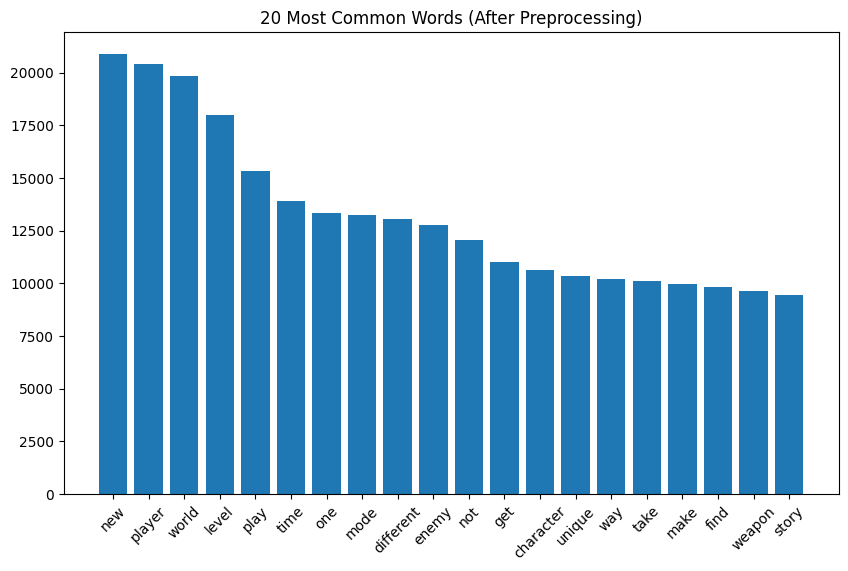

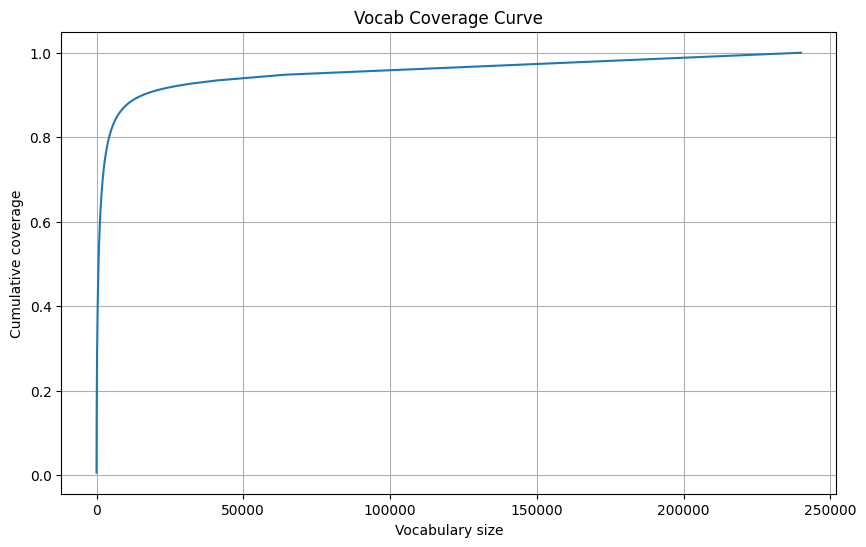

In [5]:
# --- Visualizations ---
def plot_most_common_words(input_text):
    tokens = " ".join(input_text).lower().split()
    word_counts = Counter(tokens)
    common_words = word_counts.most_common(20)
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title("20 Most Common Words (After Preprocessing)")
    plt.show()

def plot_vocab_coverage(input_text):
    tokens = " ".join(input_text).lower().split()
    word_counts = Counter(tokens)
    counts = np.array(sorted(word_counts.values(), reverse=True))
    total = counts.sum()
    cumulative_coverage = np.cumsum(counts) / total

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_coverage)
    plt.xlabel("Vocabulary size")
    plt.ylabel("Cumulative coverage")
    plt.title("Vocab Coverage Curve")
    plt.grid(True)
    plt.show()

plot_most_common_words(preprocessed_texts)
plot_vocab_coverage(preprocessed_texts)

In [8]:
# Genre Labeling
genre_list_raw = []
for genre_str in df["genres"]:
    temp = genre_str.split(';')
    temp = [x.lower() for x in temp]
    genre_list_raw.append(temp)

EXCLUDE_GENRES = ["early access", "free to play", "indie", "casual"]
all_genres = [g for sublist in genre_list_raw for g in sublist]
genre_counts = Counter(all_genres)
top_genres = [g for g, _ in genre_counts.most_common() if g not in EXCLUDE_GENRES][:10]

genre_list_processed = [[g for g in sublist if g in top_genres] for sublist in genre_list_raw]
for i in range(len(genre_list_processed)):
    if len(genre_list_processed[i]) == 0:
        genre_list_processed[i] = ["other"]

# largest class
num_action_rows = sum(1 for labels in genre_list_processed if labels == ["action"])
print(num_action_rows)

4505


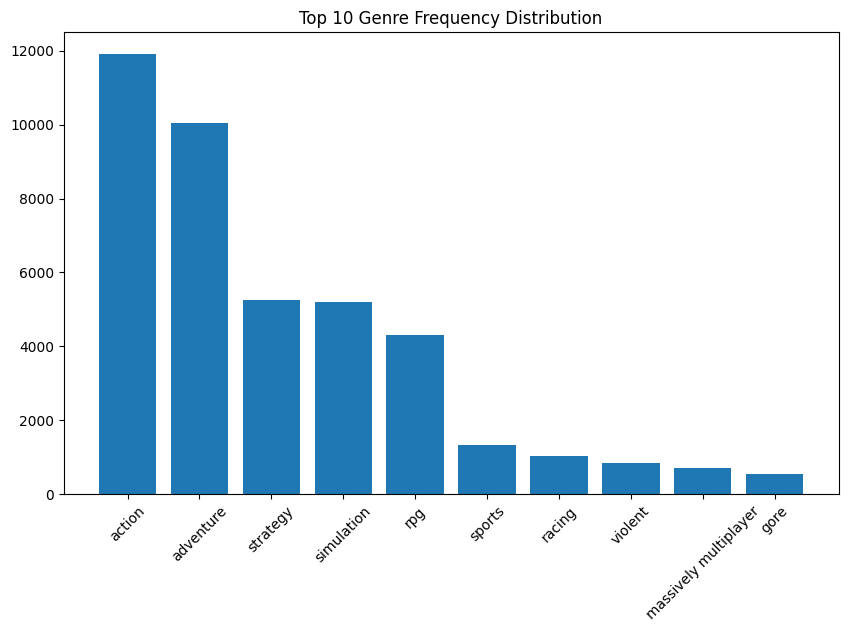

In [ ]:
def plot_genre_freq_distribution(genre_counts):
    filtered_counts = Counter({g: c for g, c in genre_counts.items() if g not in EXCLUDE_GENRES})
    common_words = filtered_counts.most_common(10)
    genre, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    plt.bar(genre, counts)
    plt.xticks(rotation=45)
    plt.title("Top 10 Genre Frequency Distribution")
    plt.show()

plot_genre_freq_distribution(genre_counts)

In [ ]:
# Prepare Data
mlb = MultiLabelBinarizer()
final_labels = mlb.fit_transform(genre_list_processed)
final_texts = preprocessed_texts
classes = mlb.classes_
print("Classes:", classes)

Classes: ['action' 'adventure' 'gore' 'massively multiplayer' 'other' 'racing'
 'rpg' 'simulation' 'sports' 'strategy' 'violent']


In [ ]:
# --- Hyperparameters ---
VOCAB_SIZE_LIMIT = 30000
MAX_SEQ_LEN = 300
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(classes) #--11 different classes
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 15
PATIENCE = 6
BATCH_SIZE = 64
TEST_SPLIT = 0.15
VAL_SPLIT = 0.2
RANDOM_SEED = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
# Vocabulary & Tokenization
words = [w for t in final_texts for w in t.split()]
freqs = Counter(words)
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + [w for w, _ in freqs.most_common(VOCAB_SIZE_LIMIT)]
stoi = {w:i for i,w in enumerate(vocab)}
VOCAB_SIZE_MODEL = len(vocab)

def encode_text(t):
    tokens = t.split()
    if len(tokens) > MAX_SEQ_LEN:
        tokens = tokens[:MAX_SEQ_LEN]
    return [stoi.get('<SOS>')] + [stoi.get(w, stoi['<UNK>']) for w in tokens] + [stoi.get('<EOS>')]

class GameDataset(Dataset):
    def __init__(self, plots, labels):
        self.data = [torch.tensor(encode_text(p), dtype=torch.long) for p in plots]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    data, labels = zip(*batch)
    padded = pad_sequence(data, batch_first=True, padding_value=0)
    return padded, torch.stack(labels)

In [ ]:
# Split Data
X_train_val, X_test, y_train_val, y_test = train_test_split(final_texts, final_labels, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VAL_SPLIT, random_state=RANDOM_SEED)

train_ds = GameDataset(X_train, y_train)
val_ds = GameDataset(X_val, y_val)
test_ds = GameDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 18410, Val size: 4603, Test size: 4062


In [ ]:
# --- Model Definitions ---
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        output, hn = self.rnn(embedded)
        hidden_cat = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(hidden_cat)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hn, cn) = self.lstm(embedded)
        hidden_cat = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(hidden_cat)

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, text):
        embedded = self.embedding(text)
        output, hn = self.gru(embedded)
        hidden_cat = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.fc(hidden_cat)

In [ ]:
# Class Weights
pos_counts = np.sum(final_labels, axis=0)
total_samples = len(final_labels)
neg_counts = total_samples - pos_counts
raw_weights = neg_counts / (pos_counts + 1e-5)
softened_weights = np.sqrt(raw_weights)
class_weights_tensor = torch.tensor(softened_weights, dtype=torch.float32).to(device)
print("Softened Pos Class Weights:", class_weights_tensor)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()

            probs = torch.sigmoid(predictions)
            preds = (probs > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return epoch_loss / len(loader), acc, f1_micro, f1_macro, prec, rec

def run_training(model_class, model_name):
    print(f"\n================ Training {model_name} (Bidirectional) ================")
    model = model_class(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_dl, optimizer, criterion)
        val_loss, acc, f1_mic, f1_mac, prec, rec = evaluate(model, val_dl, criterion)

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1 Mic: {f1_mic:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'{model_name}_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break

    print(f"Loading best {model_name} model for testing...")
    model.load_state_dict(torch.load(f'{model_name}_best.pt'))
    test_loss, t_acc, t_f1_mic, t_f1_mac, t_prec, t_rec = evaluate(model, test_dl, criterion)

    print(f"\n--- {model_name} FINAL TEST RESULTS ---")
    print(f"Loss:              {test_loss:.4f}")
    print(f"Accuracy:          {t_acc:.4f}")
    print(f"F1 Score (Micro):  {t_f1_mic:.4f}")
    print(f"F1 Score (Macro):  {t_f1_mac:.4f}")
    print(f"Precision (Macro): {t_prec:.4f}")
    print(f"Recall (Macro):    {t_rec:.4f}")

    # Return the trained model so we can save it later
    return model

Softened Pos Class Weights: tensor([1.1290, 1.3034, 7.0299, 6.0372, 2.6264, 5.0439, 2.2979, 2.0525, 4.4137,
        2.0396, 5.5783], device='cuda:0')


In [ ]:
# Run Training and Capture Models
trained_lstm = run_training(LSTMModel, "LSTM")
trained_rnn = run_training(RNNModel, "RNN")
trained_gru = run_training(GRUModel, "GRU")


================ Training LSTM (Bidirectional) ================
Epoch 1/15 | Train Loss: 0.6068 | Val Loss: 0.5789 | F1 Mic: 0.3795
Epoch 2/15 | Train Loss: 0.5258 | Val Loss: 0.5207 | F1 Mic: 0.4917
Epoch 3/15 | Train Loss: 0.4606 | Val Loss: 0.4739 | F1 Mic: 0.5710
Epoch 4/15 | Train Loss: 0.4098 | Val Loss: 0.4604 | F1 Mic: 0.5888
Epoch 5/15 | Train Loss: 0.3580 | Val Loss: 0.4698 | F1 Mic: 0.5777
Epoch 6/15 | Train Loss: 0.3059 | Val Loss: 0.4966 | F1 Mic: 0.6063
Epoch 7/15 | Train Loss: 0.2539 | Val Loss: 0.5461 | F1 Mic: 0.6147
Epoch 8/15 | Train Loss: 0.2114 | Val Loss: 0.6115 | F1 Mic: 0.6098
Epoch 9/15 | Train Loss: 0.1708 | Val Loss: 0.6725 | F1 Mic: 0.6078
Epoch 10/15 | Train Loss: 0.1366 | Val Loss: 0.7864 | F1 Mic: 0.5957
Early stopping triggered.
Loading best LSTM model for testing...


C:\Users\bruce\AppData\Local\Temp\ipykernel_15876\522583103.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_name}_best.pt'))



--- LSTM FINAL TEST RESULTS ---
Loss:              0.4666
Accuracy:          0.2927
F1 Score (Micro):  0.5873
F1 Score (Macro):  0.4637
Precision (Macro): 0.4516
Recall (Macro):    0.4999

================ Training RNN (Bidirectional) ================
Epoch 1/15 | Train Loss: 0.6373 | Val Loss: 0.6266 | F1 Mic: 0.0747
Epoch 2/15 | Train Loss: 0.6376 | Val Loss: 0.6506 | F1 Mic: 0.2414
Epoch 3/15 | Train Loss: 0.6374 | Val Loss: 0.6373 | F1 Mic: 0.1736
Epoch 4/15 | Train Loss: 0.6357 | Val Loss: 0.6277 | F1 Mic: 0.1112
Epoch 5/15 | Train Loss: 0.6255 | Val Loss: 0.6072 | F1 Mic: 0.3579
Epoch 6/15 | Train Loss: 0.6170 | Val Loss: 0.6160 | F1 Mic: 0.4204
Epoch 7/15 | Train Loss: 0.5946 | Val Loss: 0.5830 | F1 Mic: 0.3936
Epoch 8/15 | Train Loss: 0.5801 | Val Loss: 0.6229 | F1 Mic: 0.3365
Epoch 9/15 | Train Loss: 0.5726 | Val Loss: 0.5953 | F1 Mic: 0.3739
Epoch 10/15 | Train Loss: 0.5631 | Val Loss: 0.6062 | F1 Mic: 0.3668
Epoch 11/15 | Train Loss: 0.5573 | Val Loss: 0.5933 | F1 Mic: 0.31

C:\Users\bruce\AppData\Local\Temp\ipykernel_15876\522583103.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_name}_best.pt'))



--- RNN FINAL TEST RESULTS ---
Loss:              0.5848
Accuracy:          0.0918
F1 Score (Micro):  0.4052
F1 Score (Macro):  0.1943
Precision (Macro): 0.2613
Recall (Macro):    0.2000

================ Training GRU (Bidirectional) ================
Epoch 1/15 | Train Loss: 0.5682 | Val Loss: 0.4851 | F1 Mic: 0.5514
Epoch 2/15 | Train Loss: 0.4433 | Val Loss: 0.4561 | F1 Mic: 0.5939
Epoch 3/15 | Train Loss: 0.3777 | Val Loss: 0.4347 | F1 Mic: 0.6145
Epoch 4/15 | Train Loss: 0.3142 | Val Loss: 0.4581 | F1 Mic: 0.6121
Epoch 5/15 | Train Loss: 0.2488 | Val Loss: 0.5131 | F1 Mic: 0.6099
Epoch 6/15 | Train Loss: 0.1929 | Val Loss: 0.5718 | F1 Mic: 0.6118
Epoch 7/15 | Train Loss: 0.1476 | Val Loss: 0.6619 | F1 Mic: 0.5983
Epoch 8/15 | Train Loss: 0.1123 | Val Loss: 0.7255 | F1 Mic: 0.6024
Epoch 9/15 | Train Loss: 0.0867 | Val Loss: 0.7707 | F1 Mic: 0.6022
Early stopping triggered.
Loading best GRU model for testing...


C:\Users\bruce\AppData\Local\Temp\ipykernel_15876\522583103.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_name}_best.pt'))



--- GRU FINAL TEST RESULTS ---
Loss:              0.4427
Accuracy:          0.3097
F1 Score (Micro):  0.6123
F1 Score (Macro):  0.5017
Precision (Macro): 0.5031
Recall (Macro):    0.5139


In [ ]:
import os
save_path = './weights'
os.makedirs(save_path, exist_ok=True)

print(f"Weights will be saved to: {save_path}")

# Save Weights
rnn_save_file = os.path.join(save_path, 'rnn_mod1_model_weights.pth')
torch.save(trained_rnn.state_dict(), rnn_save_file)
print(f"Saved trained RNN model weights to: {rnn_save_file}")

lstm_save_file = os.path.join(save_path, 'lstm_mod1_model_weights.pth')
torch.save(trained_lstm.state_dict(), lstm_save_file)
print(f"Saved trained LSTM model weights to: {lstm_save_file}")

gru_save_file = os.path.join(save_path, 'gru_mod1_model_weights.pth')
torch.save(trained_gru.state_dict(), gru_save_file)
print(f"Saved trained GRU model weights to: {gru_save_file}")

Weights will be saved to: ./weights
Saved trained RNN model weights to: ./weights\rnn_mod1_model_weights.pth
Saved trained LSTM model weights to: ./weights\lstm_mod1_model_weights.pth
Saved trained GRU model weights to: ./weights\gru_mod1_model_weights.pth


In [ ]:
# === Export artifacts (run after training) ===
import os, json, re
from typing import Dict
import torch
import torch.nn as nn

# Compute project root (this notebook is under <root>/Games/)
ROOT = os.path.dirname(os.getcwd())
DOMAIN = "games"
BUNDLE_DIR = os.path.join(ROOT, "artifacts", DOMAIN)
os.makedirs(BUNDLE_DIR, exist_ok=True)

# 1) labels.txt
labels = None
if 'mlb' in globals() and hasattr(mlb, 'classes_'):
    labels = list(mlb.classes_)
elif 'le' in globals() and hasattr(le, 'classes_'):
    labels = list(le.classes_)
elif 'classes' in globals():
    labels = list(classes)
if not labels or len(labels) < 2:
    raise RuntimeError("Could not determine labels. Ensure 'mlb'/'le'.classes_ or a 'classes' list exists.")
labels_path = os.path.join(BUNDLE_DIR, "labels.txt")
with open(labels_path, "w", encoding="utf-8") as f:
    for lab in labels:
        f.write(f"{lab}\n")
print(f"Wrote {labels_path} ({len(labels)} labels)")

# 2) preprocessor.json
word_index: Dict[str, int] = {}
if 'stoi' in globals() and isinstance(stoi, dict):
    word_index = {str(k): int(v) for k, v in stoi.items()}
elif 'word_index' in globals() and isinstance(word_index, dict):
    word_index = word_index
elif 'vocab' in globals() and isinstance(vocab, list):
    word_index = {str(w): int(i) for i, w in enumerate(vocab)}
else:
    raise RuntimeError("Could not determine word_index ('stoi', 'word_index', or 'vocab' required).")

max_length = 256
for key in ("MAX_SEQ_LEN", "MAX_LEN", "SEQ_LEN", "MAX_LENGTH"):
    if key in globals():
        try:
            max_length = int(globals()[key])
            break
        except Exception:
            pass
lowercase = True if 'LOWERCASE' not in globals() else bool(LOWERCASE)

padding_idx = 0
if '<PAD>' in word_index:
    padding_idx = int(word_index['<PAD>'])

oov_token_id = 1
if '<UNK>' in word_index:
    oov_token_id = int(word_index['<UNK>'])

preproc = {
    "word_index": word_index,
    "max_length": int(max_length),
    "lowercase": bool(lowercase),
    "oov_token_id": int(oov_token_id),
    "padding_idx": int(padding_idx),
    "tokenizer": "regex_basic",
}
preproc_path = os.path.join(BUNDLE_DIR, "preprocessor.json")
with open(preproc_path, "w", encoding="utf-8") as f:
    json.dump(preproc, f, ensure_ascii=False)
print(f"Wrote {preproc_path} (|word_index|={len(word_index)})")

# 3) model.ts (TorchScript)
_candidates = [
    'best_model',
    'trained_lstm', 'trained_gru', 'trained_rnn',
    'lstm_model', 'gru_model', 'rnn_model',
]
model_to_export = None
model_name = None
for name in _candidates:
    if name in globals() and isinstance(globals()[name], nn.Module):
        model_to_export = globals()[name]
        model_name = name
        break
if model_to_export is None:
    raise RuntimeError("No trained model found to export. Expected one of: " + ", ".join(_candidates))

model_to_export.eval()
try:
    scripted = torch.jit.script(model_to_export)
    export_mode = "scripted"
except Exception:
    dummy = torch.ones((1, int(max_length)), dtype=torch.long)
    scripted = torch.jit.trace(model_to_export, dummy, strict=False)
    export_mode = "traced"

ts_canonical = os.path.join(BUNDLE_DIR, "model.ts")
scripted.save(ts_canonical)
print(f"Saved {export_mode} TorchScript to {ts_canonical}")

if model_name:
    ts_named = os.path.join(BUNDLE_DIR, f"{model_name}.ts")
    scripted.save(ts_named)
    print(f"Saved named TorchScript to {ts_named}")



Wrote d:\GitHub\EE6405-Final-Project\artifacts\games\labels.txt (11 labels)
Wrote d:\GitHub\EE6405-Final-Project\artifacts\games\preprocessor.json (|word_index|=30004)
Saved scripted TorchScript to d:\GitHub\EE6405-Final-Project\artifacts\games\model.ts
Saved named TorchScript to d:\GitHub\EE6405-Final-Project\artifacts\games\trained_lstm.ts


In [ ]:
# === Export per-model artifacts: metrics_{model}.json, samples_{model}.csv, confusion_matrix_{model}.csv ===
import os, json
from typing import List, Dict
import numpy as np
import pandas as pd

try:
    import torch
    import torch.nn as nn
except Exception:
    pass

ROOT = os.path.dirname(os.getcwd())
DOMAIN = os.path.basename(os.getcwd()).strip().lower()
BUNDLE_DIR = os.path.join(ROOT, "artifacts", DOMAIN)
os.makedirs(BUNDLE_DIR, exist_ok=True)

labels_path = os.path.join(BUNDLE_DIR, "labels.txt")
preproc_path = os.path.join(BUNDLE_DIR, "preprocessor.json")

if not (os.path.exists(labels_path) and os.path.exists(preproc_path)):
    print("Artifact labels/preprocessor not found. Please run export artifacts first.")
else:
    with open(labels_path, "r", encoding="utf-8") as f:
        LABELS = [line.strip() for line in f if line.strip()]
    with open(preproc_path, "r", encoding="utf-8") as f:
        preproc = json.load(f)
    word_index = preproc.get("word_index") or preproc.get("vocab") or {}
    inv_index = {int(v): str(k) for k, v in word_index.items()}

    loader = globals().get("test_dl") or globals().get("test_loader")
    if loader is None:
        print("No test loader found (test_dl/test_loader). Run this cell after training.")
    else:
        device = "cuda" if ("torch" in globals() and torch.cuda.is_available()) else "cpu"

        # Resolve hyperparameters
        VOCAB_SIZE = int(globals().get("VOCAB_SIZE_MODEL") or len(word_index) + 2)
        EMBED_DIM = int(globals().get("EMBED_DIM") or 128)
        HIDDEN_DIM = int(globals().get("HIDDEN_DIM") or 64)
        OUTPUT_DIM = int(globals().get("OUTPUT_DIM") or len(LABELS))
        NUM_LAYERS = int(globals().get("NUM_LAYERS") or 1)
        DROPOUT = float(globals().get("DROPOUT") or 0.5)

        model_specs = [
            ("rnn", "RNN_best.pt", globals().get("RNNModel")),
            ("lstm", "LSTM_best.pt", globals().get("LSTMModel")),
            ("gru", "GRU_best.pt", globals().get("GRUModel")),
        ]

        from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

        for mk, ckpt_name, model_cls in model_specs:
            if model_cls is None or not os.path.exists(ckpt_name):
                print(f"Skip {mk}: class or checkpoint not found ({ckpt_name}).")
                continue
            try:
                model = model_cls(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
                model.load_state_dict(torch.load(ckpt_name, map_location=device))
                model.eval()

                y_true_top1: List[int] = []
                y_pred_top1: List[int] = []
                y_true_bin_list: List[np.ndarray] = []
                y_pred_bin_list: List[np.ndarray] = []
                samples: List[Dict[str, object]] = []
                max_samples = 200

                with torch.no_grad():
                    for batch in loader:
                        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                            X, y = batch[0], batch[1]
                        else:
                            X = batch["inputs"] if isinstance(batch, dict) else batch[0]
                            y = batch["labels"] if isinstance(batch, dict) else batch[1]
                        X = X.to(device)
                        logits = model(X)
                        if isinstance(logits, (list, tuple)):
                            logits = logits[0]
                        logits = logits.float()
                        probs = torch.sigmoid(logits).detach().cpu().numpy()
                        y_cpu = y.detach().cpu().numpy()

                        y_pred_b = (probs > 0.5).astype(int)
                        y_true_bin_list.append(y_cpu.astype(int))
                        y_pred_bin_list.append(y_pred_b)

                        y_true_top1.extend(np.argmax(y_cpu, axis=1).tolist())
                        y_pred_top1.extend(np.argmax(probs, axis=1).tolist())

                        if len(samples) < max_samples:
                            X_cpu = X.detach().cpu().numpy()
                            for i in range(min(len(X_cpu), max_samples - len(samples))):
                                ids = [int(t) for t in X_cpu[i].tolist() if int(t) != 0]
                                toks = [inv_index.get(t, "<unk>") for t in ids]
                                text = " ".join(toks)[:500]
                                true_idx = int(np.argmax(y_cpu[i]))
                                pred_idx = int(np.argmax(probs[i]))
                                true_labels = [LABELS[j] for j, v in enumerate(y_cpu[i].tolist()) if int(v) == 1]
                                pred_labels = [LABELS[j] for j, v in enumerate(y_pred_b[i].tolist()) if int(v) == 1]
                                samples.append({
                                    "text": text,
                                    "true": LABELS[true_idx],
                                    "pred": LABELS[pred_idx],
                                    "prob_pred": float(probs[i][pred_idx]),
                                    "correct": int(true_idx == pred_idx),
                                    "true_labels": "|".join(true_labels),
                                    "pred_labels": "|".join(pred_labels),
                                })

                y_true_bin = np.vstack(y_true_bin_list) if y_true_bin_list else np.zeros((0, len(LABELS)), dtype=int)
                y_pred_bin = np.vstack(y_pred_bin_list) if y_pred_bin_list else np.zeros((0, len(LABELS)), dtype=int)
                y_true_top1 = np.asarray(y_true_top1, dtype=int)
                y_pred_top1 = np.asarray(y_pred_top1, dtype=int)

                acc_top1 = float((y_true_top1 == y_pred_top1).mean()) if y_true_top1.size else 0.0
                pr, rc, f1w, _ = precision_recall_fscore_support(
                    y_true_top1, y_pred_top1, labels=list(range(len(LABELS))), average="weighted", zero_division=0
                )
                _, _, f1micro, _ = precision_recall_fscore_support(
                    y_true_top1, y_pred_top1, labels=list(range(len(LABELS))), average="micro", zero_division=0
                )
                _, _, f1macro, _ = precision_recall_fscore_support(
                    y_true_top1, y_pred_top1, labels=list(range(len(LABELS))), average="macro", zero_division=0
                )
                subset_acc = float((y_true_bin == y_pred_bin).all(axis=1).mean()) if y_true_bin.size else 0.0

                metrics = {
                    "accuracy": acc_top1,
                    "precision": float(pr),
                    "recall": float(rc),
                    "f1_micro": float(f1micro),
                    "f1_macro": float(f1macro),
                    "f1_weighted": float(f1w),
                }

                cm = confusion_matrix(y_true_top1, y_pred_top1, labels=list(range(len(LABELS))))
                cm_df = pd.DataFrame(cm, index=pd.Index(LABELS, name="true"), columns=pd.Index(LABELS, name="pred"))

                with open(os.path.join(BUNDLE_DIR, f"metrics_{mk}.json"), "w", encoding="utf-8") as f:
                    json.dump(metrics, f, ensure_ascii=False, indent=2)
                cm_df.to_csv(os.path.join(BUNDLE_DIR, f"confusion_matrix_{mk}.csv"))
                pd.DataFrame(samples).to_csv(os.path.join(BUNDLE_DIR, f"samples_{mk}.csv"), index=False)
                print(f"[{mk}] wrote metrics_{mk}.json, confusion_matrix_{mk}.csv, samples_{mk}.csv")
            except Exception as e:
                print(f"[{mk}] export failed: {e}")

C:\Users\bruce\AppData\Local\Temp\ipykernel_15876\3290988132.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_name, map_location=de

[rnn] wrote metrics_rnn.json, confusion_matrix_rnn.csv, samples_rnn.csv


C:\Users\bruce\AppData\Local\Temp\ipykernel_15876\3290988132.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_name, map_location=de

[lstm] wrote metrics_lstm.json, confusion_matrix_lstm.csv, samples_lstm.csv


C:\Users\bruce\AppData\Local\Temp\ipykernel_15876\3290988132.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_name, map_location=de

[gru] wrote metrics_gru.json, confusion_matrix_gru.csv, samples_gru.csv
